## Week 6 assignment

##### Setup

Use the dataset containing short sentences translated from English to Finnish (fin-eng.zip), that can be downloaded at https://www.manythings.org/anki/.

##### Task

Build and train a Transformer model to translate sentences from English to Finnish with the dataset referred to above. You can use the same classes for embedding (token + positional) layer and Transformer encoder and decoder as in Chollet's "Deep Learning with Python" and weekly material. As for the actual model, follow the similar example with English-Spanish translation in Chollet's book; also, you can use the code below to read the sentences from the file:

```python
text_file = "fin-eng/fin.txt"

with open(text_file, encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, finnish, rest = line.split("\t")
    finnish = "[start] " + finnish + " [end]"
    text_pairs.append((english, finnish))
```

Provide the notebook also with a couple of examples showing translated sentences. If the results are less than impressive, never mind; a genuine effort is all that is expected of this exercise.


#### Data preparation

Fetching data from text file and constructing english, finnish word pairs from it.

In [1]:
# Discard unnessecary logs from gpu
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU devices:", tf.config.list_physical_devices('GPU'))

print(tf.__version__)
print(tf.__path__)



E0000 00:00:1745839652.394190    6486 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745839652.399306    6486 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745839652.412078    6486 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745839652.412115    6486 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745839652.412118    6486 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745839652.412119    6486 computation_placer.cc:177] computation placer already registered. Please check linka

Num GPUs Available: 1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.19.0
['/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/keras/api/_v2', '/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/keras/_tf_keras', '/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/tensorflow', '/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/tensorflow/_api/v2']


In [2]:
import random

# Extract text from file to

text_file = "../data/fin.txt"


with open(text_file, encoding="utf-8") as f:

    lines = f.read().split("\n")[:-1]

text_pairs = []

for line in lines:
    english, finnish, rest = line.split("\t")
    finnish = "[start] " + finnish + " [end]"
    text_pairs.append((english, finnish))

random.choice(text_pairs)

('Spare the rod and spoil the child.',
 '[start] Joka vitsaa säästää, se lastaan vihaa. [end]')

#### Splitting dataset to train, validation and test sets

In [3]:
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

#### Vectorization of word pairs

In [4]:
import tensorflow as tf
import string
import re
from keras import layers



strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")


vocab_size = 50000
seq_len = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=seq_len
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=seq_len + 1,
    standardize=custom_standardization,
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_fin_texts = [pair[1] for pair in train_pairs]

source_vectorization.adapt(train_eng_texts)
target_vectorization.adapt(train_fin_texts)

I0000 00:00:1745839655.817845    6486 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1


#### Dataset preparation for translation task

In [20]:
batch_size = 16

# Pre-vectorize all data
train_eng_vec = source_vectorization(tf.constant(train_eng_texts))
train_fin_vec = target_vectorization(tf.constant(train_fin_texts))
val_eng_vec = source_vectorization(tf.constant([pair[0] for pair in val_pairs]))
val_fin_vec = target_vectorization(tf.constant([pair[1] for pair in val_pairs]))

print(target_vectorization.get_vocabulary())


def format_vectorized_dataset(eng, fin):
    return ({"english": eng, "finnish": fin[:, :-1]}, fin[:, 1:])


train_ds = tf.data.Dataset.from_tensor_slices((train_eng_vec, train_fin_vec))
train_ds = train_ds.batch(batch_size).map(format_vectorized_dataset).cache().shuffle(2048).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_eng_vec, val_fin_vec))
val_ds = val_ds.batch(batch_size).map(format_vectorized_dataset).cache().prefetch(tf.data.AUTOTUNE)


['', '[UNK]', np.str_('[start]'), np.str_('[end]'), np.str_('on'), np.str_('tom'), np.str_('ei'), np.str_('tomi'), np.str_('hän'), np.str_('että'), np.str_('en'), np.str_('se'), np.str_('ole'), np.str_('oli'), np.str_('minä'), np.str_('olen'), np.str_('mitä'), np.str_('sinä'), np.str_('ja'), np.str_('minun'), np.str_('tomin'), np.str_('tämä'), np.str_('sinun'), np.str_('kuin'), np.str_('sen'), np.str_('onko'), np.str_('minulle'), np.str_('niin'), np.str_('minulla'), np.str_('ranskaa'), np.str_('ovat'), np.str_('olet'), np.str_('hänen'), np.str_('sitä'), np.str_('minua'), np.str_('he'), np.str_('voi'), np.str_('kun'), np.str_('olla'), np.str_('tehdä'), np.str_('paljon'), np.str_('tomilla'), np.str_('todella'), np.str_('koskaan'), np.str_('ollut'), np.str_('kaikki'), np.str_('nyt'), np.str_('et'), np.str_('me'), np.str_('Älä'), np.str_('hyvin'), np.str_('jos'), np.str_('vain'), np.str_('mari'), np.str_('siitä'), np.str_('täytyy'), np.str_('täällä'), np.str_('mitään'), np.str_('kanssa'), 

##### Print shape of datasets

In [21]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['finnish'].shape: {inputs['finnish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (16, 20)
inputs['finnish'].shape: (16, 20)
targets.shape: (16, 20)


#### Model


##### Positional Embedding

In [22]:
from keras import layers
from keras import ops


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

##### Transformer Encoder

In [23]:
import keras


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

##### Transformer Decoder

In [24]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "dense_dim": self.dense_dim,
            }
        )
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

#### Transformer Model

In [25]:
embed_dim = 256
dense_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(seq_len, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="finnish")
x = PositionalEmbedding(seq_len, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.1)(x)
decoder_outputs = layers.Dense(len(target_vectorization.get_vocabulary()), activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ finnish             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │ 12,805,120 │ english[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │ 12,805,120 │ finnish[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  2,630,144 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  4,734,208 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, None, 256) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, None,      │  7,419,333 │ dropout_11[0][0]  │
│                     │ 28869)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,393,925 (154.09 MB)

 Trainable params: 40,393,925 (154.09 MB)

 Non-trainable params: 0 (0.00 B)

#### Train model

In [26]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

checkpoint_filepath = "./models/ckpt/checkpoint.model.keras"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

transformer.compile(
    optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint_callback])

transformer.save("transformer_fi_en.keras")

Epoch 1/30
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 111s 32ms/step - accuracy: 0.1019 - loss: 8.2304 - val_accuracy: 0.5006 - val_loss: 5.8810
Epoch 2/30
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 89s 28ms/step - accuracy: 0.5963 - loss: 5.6162 - val_accuracy: 0.4996 - val_loss: 5.3408
Epoch 3/30
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 88s 28ms/step - accuracy: 0.4513 - loss: 5.0918 - val_accuracy: 0.4089 - val_loss: 5.0771
Epoch 4/30
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 88s 28ms/step - accuracy: 0.3699 - loss: 4.7696 - val_accuracy: 0.3865 - val_loss: 4.8727
Epoch 5/30
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 88s 28ms/step - accuracy: 0.2729 - loss: 4.5009 - val_accuracy: 0.1953 - val_loss: 4.7015
Epoch 6/30
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 87s 28ms/step - accuracy: 0.1803 - loss: 4.2835 - val_accuracy: 0.1503 - val_loss: 4.5392
Epoch 7/30
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 89s 28ms/step - accuracy: 0.1532 - loss: 4.1029 - val_accuracy: 0.1529 - val_loss: 4.4200
Epoch 8/30
3162/3162 ━━━━━━━━━━━━━━━━━━━━ 87s 28ms/step - accuracy: 0.1575 

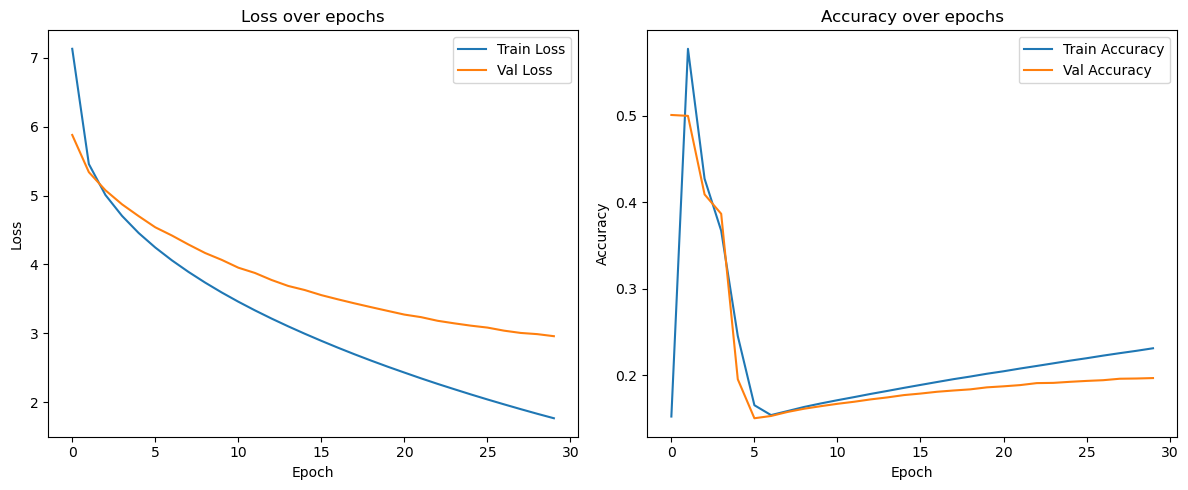

678/678 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1971 - loss: 2.9881
Test loss: 2.985759735107422
Test accuracy: 0.19673828780651093


In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Example: Evaluate on test set
test_eng_vec = source_vectorization(tf.constant([pair[0] for pair in test_pairs]))
test_fin_vec = target_vectorization(tf.constant([pair[1] for pair in test_pairs]))
test_ds = tf.data.Dataset.from_tensor_slices((test_eng_vec, test_fin_vec))
test_ds = test_ds.batch(batch_size).map(format_vectorized_dataset)
test_loss, test_acc = transformer.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

In [28]:
import numpy as np

fin_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(fin_vocab)), fin_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    tokens = decoded_sentence.split()
    tokens = [t for t in tokens if t not in ("[start]", "[end]")]
    return " ".join(tokens)

input_sentence = "This machine model is very low intelligence"
print("-")
print(input_sentence)
print(decode_sequence(input_sentence))

-
This machine model is very low intelligence
tämä kone on todella kovin viisasta
